In [1]:
!pip install -q git+https://github.com/tensorflow/docs

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [4]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

## The Auto MPG dataset

### Get the data

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

32768/30286 [================================] - 0s 13us/step


'/home/nxhuy/.keras/datasets/auto-mpg.data'

In [6]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(dataset_path, names=column_names,
                         na_values="?", comment="\t",
                         sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


### Clean the data

In [7]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [9]:
dataset = dataset.dropna()

In [10]:
dataset['Origin'] = dataset['Origin'].map(
    {1: 'USA', 2: 'Europe', 3: 'Japan'}
)

/home/nxhuy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [11]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


### Split the data into train and test

In [12]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

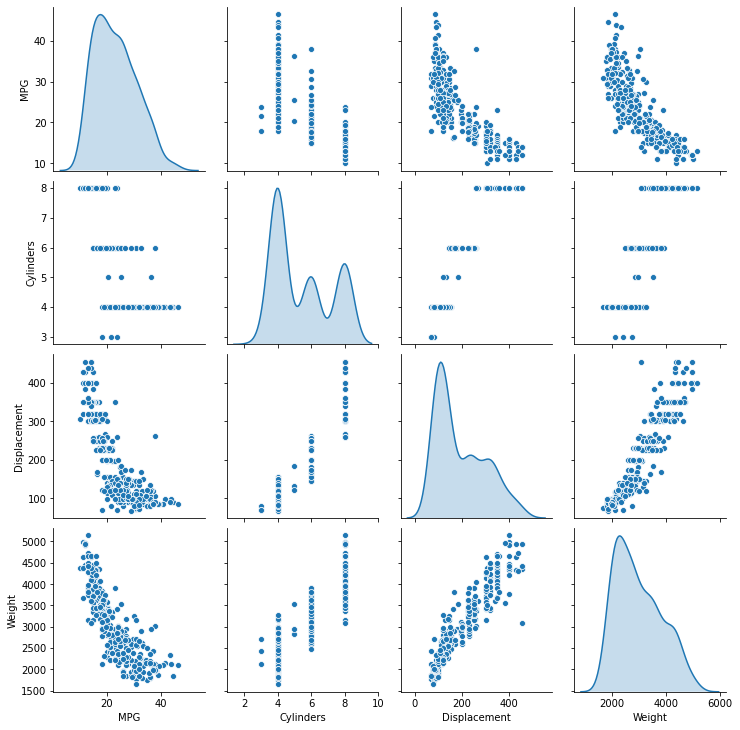

In [14]:
sns.pairplot(train_dataset[
    ["MPG", "Cylinders", "Displacement", "Weight"]
],diag_kind='kde')

In [15]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

In [16]:
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

### Normalize the data

In [17]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

## The model

### Build the model

In [18]:
train_dataset.keys()

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Europe', 'Japan', 'USA'],
      dtype='object')

In [19]:
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),
        layers.Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mse'])
    
    return model

In [20]:
model = build_model()

### Inspect the model

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [22]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[0.18693821],
       [0.22427422],
       [0.53923273],
       [0.2612044 ],
       [0.64392626],
       [0.3241765 ],
       [0.66253275],
       [0.7539695 ],
       [0.24021739],
       [0.5775318 ]], dtype=float32)

### Train the model

In [24]:
epochs = 1000

history = model.fit(
    normed_train_data,
    train_labels,
    epochs=epochs,
    validation_split=0.2,
    verbose=0,
    callbacks=[tfdocs.modeling.EpochDots()]
)


Epoch: 0, loss:5.7940,  mae:1.7277,  mse:5.7940,  val_loss:8.3630,  val_mae:2.1906,  val_mse:8.3630,  
....................................................................................................
Epoch: 100, loss:5.0729,  mae:1.5936,  mse:5.0729,  val_loss:8.0764,  val_mae:2.1952,  val_mse:8.0764,  
....................................................................................................
Epoch: 200, loss:4.6722,  mae:1.4906,  mse:4.6722,  val_loss:8.1354,  val_mae:2.2063,  val_mse:8.1354,  
....................................................................................................
Epoch: 300, loss:4.3074,  mae:1.3759,  mse:4.3074,  val_loss:8.2416,  val_mae:2.1662,  val_mse:8.2416,  
....................................................................................................
Epoch: 400, loss:4.1930,  mae:1.3766,  mse:4.1930,  val_loss:8.3664,  val_mae:2.1998,  val_mse:8.3664,  
........................................................................

In [25]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,2.376646,0.955255,2.376646,8.212013,2.198685,8.212013,995
996,2.537889,1.032873,2.537889,7.888485,2.212291,7.888485,996
997,2.482549,0.992567,2.482549,7.747185,2.141598,7.747185,997
998,2.612252,1.010286,2.612252,8.139632,2.185047,8.139632,998
999,2.412394,0.952934,2.412394,7.888101,2.156896,7.888101,999


In [26]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [MPG]')

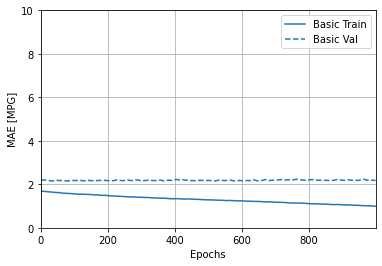

In [27]:
plotter.plot({'Basic': history}, metric="mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

Text(0, 0.5, 'MSE [MPG^2]')

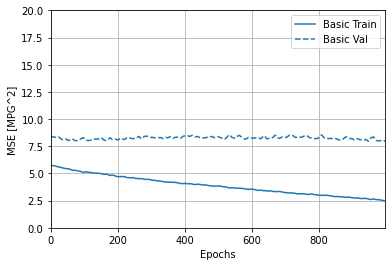

In [28]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

In [30]:
model = build_model()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=epochs, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:576.1713,  mae:22.8127,  mse:576.1713,  val_loss:559.7570,  val_mae:22.4720,  val_mse:559.7570,  
..........................................................................................

Text(0, 0.5, 'MAE [MPG]')

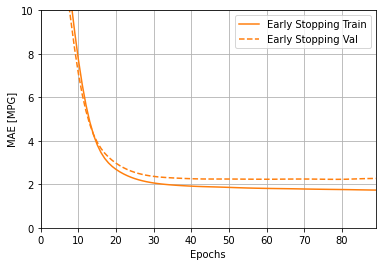

In [31]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [32]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print(f"Testing set Mean Abs Error: {mae:5.2f} MPG")

3/3 - 0s - loss: 5.3747 - mae: 1.8623 - mse: 5.3747
Testing set Mean Abs Error:  1.86 MPG


### Make predictions

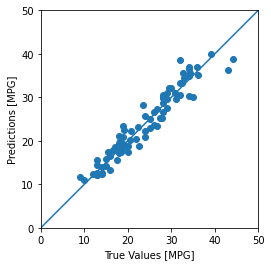

In [33]:
test_predictions = model.predict(normed_test_data).flat_input_signatureatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

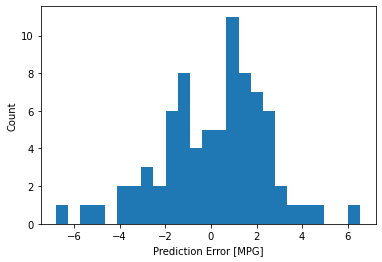

In [34]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")

## References

- https://www.tensorflow.org/tutorials/keras/regression